In [1]:
from Database import Database
import sys
# import multiprocessing as mp
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats.distributions import chi2
from bioinfokit import analys, visuz
from scipy.stats import fisher_exact
import time
from scipy.special import factorial


from fisher import pvalue_npy
from scipy.stats import chi2_contingency
from scipy.stats import uniform, randint

# Get the data

In [2]:
def get_project_ids(db):
    db.cursor.execute("""SELECT *
                            FROM project""")
    projects = db.cursor.fetchall()
    dict_project = dict()
    for proj in projects:
        dict_project[proj['ID']] = proj['project_ID']
    return dict_project

In [3]:
path_db = 'D:/Hanze_Groningen/STAGE/lastdb/db_laatste_copy.db' #'D:/Hanze_Groningen/STAGE/DATAB/copydatabase_C.db'
# Database connection
db = Database(path_db)
dict_project = get_project_ids(db)
print(len(dict_project))

43


In [4]:
df = pd.read_sql('''SELECT project.cancer, sum_dosage_GT.donor_project_ID, 
                            sum_dosage_GT.donor_ID, sum_dosage_GT.snp_ID, 
                            snp.chr, snp.pos_start, snp.pos_end 
                    FROM project, sum_dosage_GT, snp 
                    WHERE sum_dosage_GT.snp_ID=snp.ID AND 
                              sum_dosage_GT.donor_project_ID = project.ID AND 
                              (sum_dosage_GT.GT2 = 1 OR sum_dosage_GT.GT2 = 2) AND 
                              sum_dosage_GT.total_read_count_sum >= 33;''', db.mydb_connection)

# Filter data

In [5]:
df_fil = df.loc[df['chr'] != 'MT']
df_fil['chr'] ='chr' + df_fil['chr'].astype(str)

<ipython-input-5-5a2c1653c4d5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fil['chr'] ='chr' + df_fil['chr'].astype(str)


In [6]:
breast_cancer = df_fil.loc[df_fil['cancer'] == 'Breast']
# breast_cancer1 = breast_cancer[['chr', 'pos_start', 'pos_end']]
# breast_cancer1.sort_values(by=['chr', 'pos_start'], inplace=True)
breast_cancer['snp'] = breast_cancer['chr'] + '_' + breast_cancer['pos_start'].map(str) + '_' + breast_cancer['pos_end'].map(str)
print(len(list(set(breast_cancer['donor_ID']))))
num_donor_breast = len(list(set(breast_cancer['donor_ID'])))

breast_dict = dict(Counter(list(breast_cancer['snp'])))

breast_snp_count_df = pd.DataFrame([breast_dict.keys(), breast_dict.values()]).T
breast_snp_count_df.columns= ['snp', 'counts']
max_breast = breast_snp_count_df['counts'].max()
print(breast_snp_count_df['counts'].max())

breast_snp_count_df[['chr', 'pos_start', 'pos_end']] = breast_snp_count_df['snp'].str.split('_', expand=True)

breast_snp_count_df.drop('snp', axis=1, inplace=True)

sort_breast_snp_count_df = breast_snp_count_df.sort_values('counts', ascending=False)

sort_breast_snp_count_df.rename(columns={'counts': 'counts_breast'}, inplace=True)
sort_breast_snp_count_df.to_csv(f"D:/Hanze_Groningen/STAGE/R/breast_snp_count_df_maxcount_{max_breast}_donor_{num_donor_breast}_GT12_totalread_33.tsv", sep='\t', encoding='utf-8', index=False)

<ipython-input-6-3944ca0b3f7c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  breast_cancer['snp'] = breast_cancer['chr'] + '_' + breast_cancer['pos_start'].map(str) + '_' + breast_cancer['pos_end'].map(str)


286
32


In [7]:
nonbreast_cancer = df_fil.loc[df_fil['cancer'] != 'Breast']
# nonbreast_cancer1 = nonbreast_cancer[['chr', 'pos_start', 'pos_end']]
# nonbreast_cancer1.sort_values(by=['chr', 'pos_start'], inplace=True)
nonbreast_cancer['snp'] = nonbreast_cancer['chr'] + '_' + nonbreast_cancer['pos_start'].map(str) + '_' + nonbreast_cancer['pos_end'].map(str)
print(len(list(set(nonbreast_cancer['donor_ID']))))
num_donor_nonbreast = len(list(set(nonbreast_cancer['donor_ID'])))

nonbreast_dict = dict(Counter(list(nonbreast_cancer['snp'])))

nonbreast_snp_count_df = pd.DataFrame([nonbreast_dict.keys(), nonbreast_dict.values()]).T
nonbreast_snp_count_df.columns= ['snp', 'counts']

max_nonbreast = nonbreast_snp_count_df['counts'].max()
print(nonbreast_snp_count_df['counts'].max())

nonbreast_snp_count_df[['chr', 'pos_start', 'pos_end']] = nonbreast_snp_count_df['snp'].str.split('_', expand=True)

nonbreast_snp_count_df.drop('snp', axis=1, inplace=True)

sort_nonbreast_snp_count_df = nonbreast_snp_count_df.sort_values('counts', ascending=False)

sort_nonbreast_snp_count_df.rename(columns={'counts': 'counts_nonbreast'}, inplace=True)
sort_nonbreast_snp_count_df.to_csv(f"D:/Hanze_Groningen/STAGE/R/nonbreast_snp_count_df_maxcount_{max_nonbreast}_donor_{num_donor_nonbreast}_GT12_totalread_33.tsv", sep='\t', encoding='utf-8', index=False) 

<ipython-input-7-07205f4e02df>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nonbreast_cancer['snp'] = nonbreast_cancer['chr'] + '_' + nonbreast_cancer['pos_start'].map(str) + '_' + nonbreast_cancer['pos_end'].map(str)


1952
41


In [8]:
sort_breast_snp_count_df

,counts_breast,chr,pos_start,pos_end
0,32,chr3,178952085,178952085
17956,10,chr3,178936091,178936091
36345,7,chr10,8111433,8111434
181854,5,chr6,142706206,142706206
10473,5,chr2,198266834,198266834
...,...,...,...,...
190051,1,chr10,124688526,124688526
190050,1,chr8,9298794,9298794
190049,1,chr11,82124796,82124796
190048,1,chr8,27966296,27966296


In [9]:
sort_nonbreast_snp_count_df

,counts_nonbreast,chr,pos_start,pos_end
29842,41,chr12,25398284,25398284
1761075,39,chr16,23961453,23961453
1730828,32,chr4,119972341,119972341
1749930,28,chr5,124474355,124474355
1751235,26,chr12,39039796,39039796
...,...,...,...,...
2690038,1,chr18,28580490,28580490
2690037,1,chr7,62067254,62067254
2690036,1,chr7,62056082,62056082
2690035,1,chr7,62053372,62053372


### make tsv files voor R

In [13]:
breast_R = sort_breast_snp_count_df.reset_index().drop(['counts_breast', 'index'], 1)
breast_R.to_csv(f"D:/Hanze_Groningen/STAGE/R/select_inf/vs/filter/breast.tsv", sep='\t', encoding='utf-8', header=None)
breast_R

,chr,pos_start,pos_end
0,chr3,178952085,178952085
1,chr3,178936091,178936091
2,chr10,8111433,8111434
3,chr6,142706206,142706206
4,chr2,198266834,198266834
...,...,...,...
569928,chr10,124688526,124688526
569929,chr8,9298794,9298794
569930,chr11,82124796,82124796
569931,chr8,27966296,27966296


In [14]:
nonbreast_R = sort_nonbreast_snp_count_df.reset_index().drop(['counts_nonbreast', 'index'], 1)
nonbreast_R.to_csv(f"D:/Hanze_Groningen/STAGE/R/select_inf/vs/filter/nonbreast.tsv", sep='\t', encoding='utf-8', header=None)
nonbreast_R

,chr,pos_start,pos_end
0,chr12,25398284,25398284
1,chr16,23961453,23961453
2,chr4,119972341,119972341
3,chr5,124474355,124474355
4,chr12,39039796,39039796
...,...,...,...
7763471,chr18,28580490,28580490
7763472,chr7,62067254,62067254
7763473,chr7,62056082,62056082
7763474,chr7,62053372,62053372


## Merge

In [8]:
merge_b_nb = sort_breast_snp_count_df.merge(sort_nonbreast_snp_count_df, on=['chr', 'pos_start', 'pos_end'], how='outer')
# merge_b_nb[(merge_b_nb['counts_breast']>=1) & (merge_b_nb['counts_nonbreast']>=1)]
# merge_b_nb.to_csv(f"D:/Hanze_Groningen/STAGE/R/ALL_nan_df_BREAST_maxcount_{max_breast}_donor_{num_donor_breast}_NONBREAST_maxcount_{max_nonbreast}_donor_{num_donor_nonbreast}_BOTH_GT12_totalread_33.tsv", sep='\t', encoding='utf-8', index=False)
merge_b_nb

,counts_breast,chr,pos_start,pos_end,counts_nonbreast
0,32,chr3,178952085,178952085,11
1,10,chr3,178936091,178936091,8
2,7,chr10,8111433,8111434,NaN
3,5,chr6,142706206,142706206,NaN
4,5,chr2,198266834,198266834,1
...,...,...,...,...,...
8329741,NaN,chr18,28580490,28580490,1
8329742,NaN,chr7,62067254,62067254,1
8329743,NaN,chr7,62056082,62056082,1
8329744,NaN,chr7,62053372,62053372,1


In [9]:
merge_b_nb_0 = merge_b_nb.fillna(0)
merge_b_nb_0.to_csv(f"D:/Hanze_Groningen/STAGE/R/ALL_0_df_BREAST_maxcount_{max_breast}_donor_{num_donor_breast}_NONBREAST_maxcount_{max_nonbreast}_donor_{num_donor_nonbreast}_BOTH_GT12_totalread_33.tsv", sep='\t', encoding='utf-8', index=False)
merge_b_nb_0

,counts_breast,chr,pos_start,pos_end,counts_nonbreast
0,32,chr3,178952085,178952085,11
1,10,chr3,178936091,178936091,8
2,7,chr10,8111433,8111434,0
3,5,chr6,142706206,142706206,0
4,5,chr2,198266834,198266834,1
...,...,...,...,...,...
8329741,0,chr18,28580490,28580490,1
8329742,0,chr7,62067254,62067254,1
8329743,0,chr7,62056082,62056082,1
8329744,0,chr7,62053372,62053372,1


# Chi-square

In [10]:
# from scipy.stats import chi2_contingency
  
# # defining the table
# #
# #       donor   |  snp
# #  b  | 285     | 22
# #  nb | 1885    | 7
# data = [[285, 22], [1885, 7]]
# stat, p, dof, expected = chi2_contingency(data)
  
# # interpret p-value
# alpha = 0.05
# print("p value is " + str(p))
# if p <= alpha:
#     print('Dependent (reject H0)')
# else:
#     print('Independent (H0 holds true)')

In [11]:
merge_b_nb_0['counts_nonbreast_plus'] = merge_b_nb_0['counts_nonbreast'] + (1/1885)
merge_b_nb_0['counts_breast_plus'] = merge_b_nb_0['counts_breast'] + (1/285)

In [12]:
n = np.array([285, 1885])
S = merge_b_nb_0[['counts_breast_plus', 'counts_nonbreast_plus']].to_numpy() #+1
f = n / n.sum()
E1 = S.sum(axis=1)[:,None]*f
C = (n-S)
E2 = C.sum(axis=1)[:,None]*f
D1 = ((E1-S)**2/E1).sum(axis=1)
D2 = ((E2-C)/E2).sum(axis=1)
X2 = D1 + D2
X2

array([141.6584631 ,  28.4320468 ,  46.33506066, ...,   0.14345081,
         0.14345081,   0.14345081])

In [13]:
p_value_X2 = chi2.sf(X2,1)

In [14]:
constant = np.log(n[0]) - np.log(n[1])
log2_fc = (np.log(S[:, 0]) - np.log(S[:, 1]) - constant) / np.log(2)
log2_fc

array([ 4.26618769,  3.04786925, 16.4139574 , ..., -5.43005256,
       -5.43005256, -5.43005256])

In [15]:
log10_p_value = -np.log10(p_value_X2)
log10_p_value

array([31.9374391 ,  7.01302448, 11.00145946, ...,  0.15188835,
        0.15188835,  0.15188835])

In [16]:
merge_b_nb_0['X2'] = X2
merge_b_nb_0['p_value_X2'] = p_value_X2
merge_b_nb_0['log10_p_value'] = log10_p_value # -log10(p-value)
merge_b_nb_0['log2_fc'] = log2_fc # log2(FC)

# Fisher exact

In [17]:
S_F = merge_b_nb_0[['counts_breast', 'counts_nonbreast']].to_numpy()
C_F = (n-S_F)
S_F = S_F.astype(np.uint)
C_F = C_F.astype(np.uint)

### First try

In [18]:
# Fisher
# conda install -c bioconda fisher
# https://stackoverflow.com/questions/34947578/how-to-vectorize-fishers-exact-test
from fisher import pvalue_npy

_, _, twosided = pvalue_npy(S_F[:, 0], C_F[:, 0], S_F[:, 1], C_F[:, 1])
odds = (S_F[:, 0] * C_F[:, 1]) / (C_F[:, 0] * S_F[:, 1])

print("result fast p and odds", odds[0], twosided[0])

result fast p and odds 21.54796981674452 4.1383806642991494e-07


<ipython-input-18-55ae7fddeadc>:7: RuntimeWarning: divide by zero encountered in true_divide
  odds = (S_F[:, 0] * C_F[:, 1]) / (C_F[:, 0] * S_F[:, 1])


In [19]:
merge_b_nb_0['p_value_F_TEST'] = twosided
merge_b_nb_0['p_value_F_TEST'].corr(merge_b_nb_0['p_value_X2'])

0.9603420502196723

In [20]:
twosided

array([4.13838066e-07, 2.17950488e-05, 6.31911434e-07, ...,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00])

### Second try

In [21]:
S_C = np.concatenate((S, C), axis=1)
S_C

array([[3.20035088e+01, 1.10005305e+01, 2.52996491e+02, 1.87399947e+03],
       [1.00035088e+01, 8.00053050e+00, 2.74996491e+02, 1.87699947e+03],
       [7.00350877e+00, 5.30503979e-04, 2.77996491e+02, 1.88499947e+03],
       ...,
       [3.50877193e-03, 1.00053050e+00, 2.84996491e+02, 1.88399947e+03],
       [3.50877193e-03, 1.00053050e+00, 2.84996491e+02, 1.88399947e+03],
       [3.50877193e-03, 1.00053050e+00, 2.84996491e+02, 1.88399947e+03]])

In [ ]:
# #https://www.geeksforgeeks.org/python-program-for-factorial-of-a-number/
# def factorial(n):     
#     # single line to find factorial
#     return 1 if (n==1 or n==0) else n * factorial(n - 1);

# x = (factorial(285)*factorial(1885)*factorial(22+7)*factorial((285+1885)-(22+7)))
# y = (factorial(22)*factorial(285-22)*factorial(7)*factorial(1885-7)*factorial(285+1885))
# z = x/y
# print(z)

In [ ]:
# import time
# start_time = time.perf_counter()

# p_value_F_self = list()
# for index, value in enumerate(S_C):
#     x = (factorial(value[0]+value[2])*factorial(value[1]+value[3])*factorial(value[0]+value[1])*factorial(value[2]+value[3]))
#     y = (factorial(value[0])*factorial(value[2])*factorial(value[1])*factorial(value[3])*factorial(value[0]+value[1]+value[2]+value[3]))
#     z = x/y
#     p_value_F_self.append(z)
#     if (index%100000) == 0:
#         print(len(p_value_F_self))
# print(len(p_value_F_self))

# print("--- %s seconds ---" % (time.perf_counter() - start_time))

In [24]:
# from scipy.special import factorial
# x = factorial(S_C[:, 0]+S_C[:, 2])*factorial(S_C[:, 1]+S_C[:, 3])*factorial(S_C[:, 0]+S_C[:, 1])*factorial(S_C[:, 2]+S_C[:, 3])
# y = factorial(S_C[:, 0])*factorial(S_C[:, 2])*factorial(S_C[:, 1])*factorial(S_C[:, 3])*factorial(S_C[:, 0]+S_C[:, 1]+S_C[:, 2]+S_C[:, 3])
# z = x/y
# z

<ipython-input-24-9cf2508e61c6>:4: RuntimeWarning: invalid value encountered in true_divide
  z = x/y


array([nan, nan, nan, ..., nan, nan, nan])

In [30]:
# x = S_C[:, 0]+S_C[:, 2]
# # factorial(S_C[:, 0])#*
# # factorial(S_C[:, 1]+S_C[:, 3])

inf

### Third try

In [31]:
# from scipy.stats import fisher_exact
# table = np.array([[22, (285-22)], [7, (1885-7)]])
# oddsr, p = fisher_exact(table, alternative='two-sided')
# p

1.2708355912531913e-14

In [32]:
import time
start_time = time.perf_counter()

p_value_F = list()
for index, value in enumerate(S_C):
    table = np.array([[value[0], value[2]], [value[1], value[3]]])
    oddsr, p = fisher_exact(table, alternative='two-sided')
    p_value_F.append(p)
    if (index%100000) == 0:
        print(len(p_value_F))
print(len(p_value_F))

print("--- %s seconds ---" % (time.perf_counter() - start_time))

1
100001
200001
300001
400001
500001
600001
700001
800001
900001
1000001
1100001
1200001
1300001
1400001
1500001
1600001
1700001
1800001
1900001
2000001
2100001
2200001
2300001
2400001
2500001
2600001
2700001
2800001
2900001
3000001
3100001
3200001
3300001
3400001
3500001
3600001
3700001
3800001
3900001
4000001
4100001
4200001
4300001
4400001
4500001
4600001
4700001
4800001
4900001
5000001
5100001
5200001
5300001
5400001
5500001
5600001
5700001
5800001
5900001
6000001
6100001
6200001
6300001
6400001
6500001
6600001
6700001
6800001
6900001
7000001
7100001
7200001
7300001
7400001
7500001
7600001
7700001
7800001
7900001
8000001
8100001
8200001
8300001
8329746
--- 3819.4567842 seconds ---


In [33]:
merge_b_nb_0['p_value_F'] = p_value_F
merge_b_nb_0['p_value_F'].corr(merge_b_nb_0['p_value_X2'])

0.9603418055343118

In [ ]:
# import time
# start_time = time.perf_counter()

# for i in range(0,10000):    
#     table = np.array([[merge_b_nb_0.iloc[i,0], (285-merge_b_nb_0.iloc[i,0])], [merge_b_nb_0.iloc[i,4], (1885-merge_b_nb_0.iloc[i,4])]])
#     oddsr, p = fisher_exact(table, alternative='two-sided')
# print("--- %s seconds ---" % (time.perf_counter() - start_time))
    

# Write

In [34]:
merge_b_nb_0.to_csv(f"D:/Hanze_Groningen/STAGE/R/ALL_p_valueANDfc_df_BREAST_maxcount_{max_breast}_donor_{num_donor_breast}_NONBREAST_maxcount_{max_nonbreast}_donor_{num_donor_nonbreast}_BOTH_GT12_totalread_33.tsv", sep='\t', encoding='utf-8', index=False)

## chi test2

In [35]:
import time
start_time = time.perf_counter()

p_value_X2_TEST = list()
for index, value in enumerate(S_C):
    table = np.array([[value[0], value[2]], [value[1], value[3]]])
    stat, p, dof, expected = chi2_contingency(table)
    p_value_X2_TEST.append(p)
    if (index%100000) == 0:
        print(len(p_value_X2_TEST))
print(len(p_value_X2_TEST))

print("--- %s seconds ---" % (time.perf_counter() - start_time))

1
100001
200001
300001
400001
500001
600001
700001
800001
900001
1000001
1100001
1200001
1300001
1400001
1500001
1600001
1700001
1800001
1900001
2000001
2100001
2200001
2300001
2400001
2500001
2600001
2700001
2800001
2900001
3000001
3100001
3200001
3300001
3400001
3500001
3600001
3700001
3800001
3900001
4000001
4100001
4200001
4300001
4400001
4500001
4600001
4700001
4800001
4900001
5000001
5100001
5200001
5300001
5400001
5500001
5600001
5700001
5800001
5900001
6000001
6100001
6200001
6300001
6400001
6500001
6600001
6700001
6800001
6900001
7000001
7100001
7200001
7300001
7400001
7500001
7600001
7700001
7800001
7900001
8000001
8100001
8200001
8300001
8329746
--- 2144.6390689 seconds ---


In [36]:
merge_b_nb_0['p_value_X2_TEST'] = p_value_X2_TEST
merge_b_nb_0['p_value_F'].corr(merge_b_nb_0['p_value_X2_TEST'])

0.11973192646419863

In [37]:
merge_b_nb_0.to_csv(f"D:/Hanze_Groningen/STAGE/R/ALL2_p_valueANDfc_df_BREAST_maxcount_{max_breast}_donor_{num_donor_breast}_NONBREAST_maxcount_{max_nonbreast}_donor_{num_donor_nonbreast}_BOTH_GT12_totalread_33.tsv", sep='\t', encoding='utf-8', index=False)

# Volcano plot

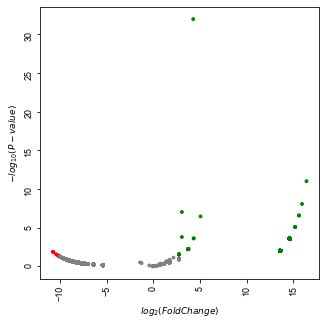

In [38]:
#plot and open . This will not save the image
plt = visuz.GeneExpression.volcano(df=merge_b_nb_0,lfc='log2_fc',pv='p_value_X2',show=True)
# plt.axhline()

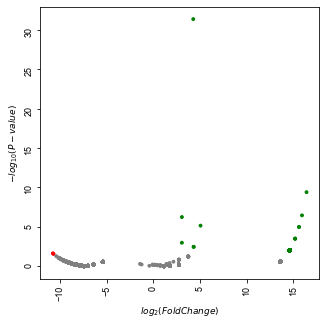

In [39]:
#plot and open . This will not save the image
plt = visuz.GeneExpression.volcano(df=merge_b_nb_0,lfc='log2_fc',pv='p_value_X2_TEST',show=True)
# plt.axhline()

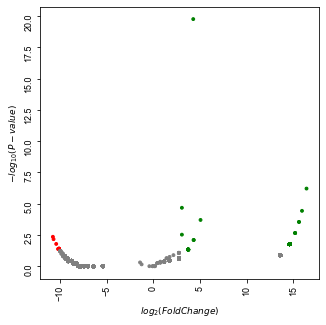

In [40]:
#plot and open . This will not save the image
plt = visuz.GeneExpression.volcano(df=merge_b_nb_0,lfc='log2_fc',pv='p_value_F',show=True)
# plt.axhline()

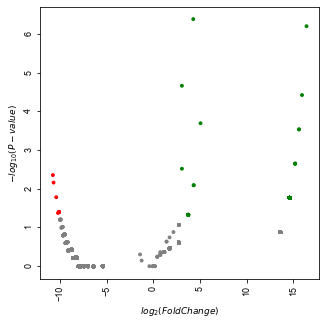

In [41]:
#plot and open . This will not save the image
plt = visuz.GeneExpression.volcano(df=merge_b_nb_0,lfc='log2_fc',pv='p_value_F_TEST',show=True)
# plt.axhline()

# Filter on mutations 

In [44]:
merge_b_nb_0

,counts_breast,chr,pos_start,pos_end,counts_nonbreast,counts_nonbreast_plus,counts_breast_plus,X2,p_value_X2,log10_p_value,log2_fc,p_value_F_TEST,p_value_F,p_value_X2_TEST
0,32,chr3,178952085,178952085,11,11.000531,32.003509,141.658463,1.154944e-32,31.937439,4.266188,4.138381e-07,1.747168e-20,4.377189e-32
1,10,chr3,178936091,178936091,8,8.000531,10.003509,28.432047,9.704553e-08,7.013024,3.047869,2.179505e-05,2.128542e-05,5.675622e-07
2,7,chr10,8111433,8111434,0,0.000531,7.003509,46.335061,9.966451e-12,11.001459,16.413957,6.319114e-07,6.203878e-07,3.939304e-10
3,5,chr6,142706206,142706206,0,0.000531,5.003509,33.101788,8.745828e-09,8.058199,15.928820,3.789738e-05,3.740472e-05,3.461343e-07
4,5,chr2,198266834,198266834,1,1.000531,5.003509,25.948804,3.505926e-07,6.455197,5.047706,2.028779e-04,2.003046e-04,6.961756e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8329741,0,chr18,28580490,28580490,1,1.000531,0.003509,0.143451,7.048743e-01,0.151888,-5.430053,1.000000e+00,1.000000e+00,2.720620e-01
8329742,0,chr7,62067254,62067254,1,1.000531,0.003509,0.143451,7.048743e-01,0.151888,-5.430053,1.000000e+00,1.000000e+00,2.720620e-01
8329743,0,chr7,62056082,62056082,1,1.000531,0.003509,0.143451,7.048743e-01,0.151888,-5.430053,1.000000e+00,1.000000e+00,2.720620e-01
8329744,0,chr7,62053372,62053372,1,1.000531,0.003509,0.143451,7.048743e-01,0.151888,-5.430053,1.000000e+00,1.000000e+00,2.720620e-01


In [46]:
filter_number = 1
mutations_more_than = merge_b_nb_0[(merge_b_nb_0["counts_breast"]>filter_number) | (merge_b_nb_0["counts_nonbreast"]>filter_number)]
mutations_more_than.to_csv(f"D:/Hanze_Groningen/STAGE/R/morethan{filter_number}_p_valueANDfc_df_BREAST_maxcount_{max_breast}_donor_{num_donor_breast}_NONBREAST_maxcount_{max_nonbreast}_donor_{num_donor_nonbreast}_BOTH_GT12_totalread_33.tsv", sep='\t', encoding='utf-8', index=False)
mutations_more_than

,counts_breast,chr,pos_start,pos_end,counts_nonbreast,counts_nonbreast_plus,counts_breast_plus,X2,p_value_X2,log10_p_value,log2_fc,p_value_F_TEST,p_value_F,p_value_X2_TEST
0,32,chr3,178952085,178952085,11,11.000531,32.003509,141.658463,1.154944e-32,31.937439,4.266188,4.138381e-07,1.747168e-20,4.377189e-32
1,10,chr3,178936091,178936091,8,8.000531,10.003509,28.432047,9.704553e-08,7.013024,3.047869,2.179505e-05,2.128542e-05,5.675622e-07
2,7,chr10,8111433,8111434,0,0.000531,7.003509,46.335061,9.966451e-12,11.001459,16.413957,6.319114e-07,6.203878e-07,3.939304e-10
3,5,chr6,142706206,142706206,0,0.000531,5.003509,33.101788,8.745828e-09,8.058199,15.928820,3.789738e-05,3.740472e-05,3.461343e-07
4,5,chr2,198266834,198266834,1,1.000531,5.003509,25.948804,3.505926e-07,6.455197,5.047706,2.028779e-04,2.003046e-04,6.961756e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2055252,0,chr4,134833054,134833054,2,2.000531,0.003509,0.294199,5.875421e-01,0.230961,-6.429670,1.000000e+00,1.000000e+00,6.151069e-01
2055253,0,chr2,193997052,193997052,2,2.000531,0.003509,0.294199,5.875421e-01,0.230961,-6.429670,1.000000e+00,1.000000e+00,6.151069e-01
2055254,0,chr7,67621522,67621522,2,2.000531,0.003509,0.294199,5.875421e-01,0.230961,-6.429670,1.000000e+00,1.000000e+00,6.151069e-01
2055255,0,chr12,80807967,80807967,2,2.000531,0.003509,0.294199,5.875421e-01,0.230961,-6.429670,1.000000e+00,1.000000e+00,6.151069e-01


In [47]:
filter_number = 2
mutations_more_than = merge_b_nb_0[(merge_b_nb_0["counts_breast"]>filter_number) | (merge_b_nb_0["counts_nonbreast"]>filter_number)]
mutations_more_than.to_csv(f"D:/Hanze_Groningen/STAGE/R/morethan{filter_number}_p_valueANDfc_df_BREAST_maxcount_{max_breast}_donor_{num_donor_breast}_NONBREAST_maxcount_{max_nonbreast}_donor_{num_donor_nonbreast}_BOTH_GT12_totalread_33.tsv", sep='\t', encoding='utf-8', index=False)
mutations_more_than

,counts_breast,chr,pos_start,pos_end,counts_nonbreast,counts_nonbreast_plus,counts_breast_plus,X2,p_value_X2,log10_p_value,log2_fc,p_value_F_TEST,p_value_F,p_value_X2_TEST
0,32,chr3,178952085,178952085,11,11.000531,32.003509,141.658463,1.154944e-32,31.937439,4.266188,4.138381e-07,1.747168e-20,4.377189e-32
1,10,chr3,178936091,178936091,8,8.000531,10.003509,28.432047,9.704553e-08,7.013024,3.047869,2.179505e-05,2.128542e-05,5.675622e-07
2,7,chr10,8111433,8111434,0,0.000531,7.003509,46.335061,9.966451e-12,11.001459,16.413957,6.319114e-07,6.203878e-07,3.939304e-10
3,5,chr6,142706206,142706206,0,0.000531,5.003509,33.101788,8.745828e-09,8.058199,15.928820,3.789738e-05,3.740472e-05,3.461343e-07
4,5,chr2,198266834,198266834,1,1.000531,5.003509,25.948804,3.505926e-07,6.455197,5.047706,2.028779e-04,2.003046e-04,6.961756e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
646820,0,chr4,108445761,108445761,3,3.000531,0.003509,0.444983,5.047272e-01,0.296943,-7.014505,1.000000e+00,1.000000e+00,8.522364e-01
646821,0,chr10,82955958,82955958,3,3.000531,0.003509,0.444983,5.047272e-01,0.296943,-7.014505,1.000000e+00,1.000000e+00,8.522364e-01
646822,0,chr3,53883722,53883722,3,3.000531,0.003509,0.444983,5.047272e-01,0.296943,-7.014505,1.000000e+00,1.000000e+00,8.522364e-01
646823,0,chr13,63636450,63636450,3,3.000531,0.003509,0.444983,5.047272e-01,0.296943,-7.014505,1.000000e+00,1.000000e+00,8.522364e-01


In [55]:
filter_number = 0
mutations_more_than = merge_b_nb_0[(merge_b_nb_0["counts_breast"]>filter_number)]
mutations_more_than.to_csv(f"D:/Hanze_Groningen/STAGE/R/BREASTmorethan{filter_number}_p_valueANDfc_df_BREAST_maxcount_{max_breast}_donor_{num_donor_breast}_NONBREAST_maxcount_{max_nonbreast}_donor_{num_donor_nonbreast}_BOTH_GT12_totalread_33.tsv", sep='\t', encoding='utf-8', index=False)
mutations_more_than

,counts_breast,chr,pos_start,pos_end,counts_nonbreast,counts_nonbreast_plus,counts_breast_plus,X2,p_value_X2,log10_p_value,log2_fc,p_value_F_TEST,p_value_F,p_value_X2_TEST
0,32,chr3,178952085,178952085,11,11.000531,32.003509,141.658463,1.154944e-32,31.937439,4.266188,4.138381e-07,1.747168e-20,4.377189e-32
1,10,chr3,178936091,178936091,8,8.000531,10.003509,28.432047,9.704553e-08,7.013024,3.047869,2.179505e-05,2.128542e-05,5.675622e-07
2,7,chr10,8111433,8111434,0,0.000531,7.003509,46.335061,9.966451e-12,11.001459,16.413957,6.319114e-07,6.203878e-07,3.939304e-10


In [ ]:
filter_number = 0
mutations_more_than = merge_b_nb_0[(merge_b_nb_0["counts_nonbreast"]>filter_number)]
mutations_more_than.to_csv(f"D:/Hanze_Groningen/STAGE/R/NONBREASTmorethan{filter_number}_p_valueANDfc_df_BREAST_maxcount_{max_breast}_donor_{num_donor_breast}_NONBREAST_maxcount_{max_nonbreast}_donor_{num_donor_nonbreast}_BOTH_GT12_totalread_33.tsv", sep='\t', encoding='utf-8', index=False)
mutations_more_than

# Manhattan